In [46]:
# added this to get tab-complete working on theta
%config Completer.use_jedi = False
import os,sys,json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing as mp

In [210]:
base_path = '/lus/theta-fs0/logs/pythonlogging/module_usage/'
check_for_modules = ['tensorflow','torch','horovod','pandas','matplotlib','h5py','sklearn','numpy','scipy','balsam']

In [240]:
def commonize_source(source):
    try:
        if source.startswith('/soft/'):
            source = source.replace('/soft/','/lus/theta-fs0/software/')
        elif source.startswith('/projects/'):
            source = source.replace('/projects/','/lus/theta-fs0/projects/')
        elif source.startswith('/home/'):
            source = source.replace('/home/','/gpfs/mira-home/')
        
        if source.endswith('python3.8'):
            source = source.replace('python3.8','python')
        elif source.endswith('python3.7'):
            source = source.replace('python3.7','python')
        elif source.endswith('python3'):
            source = source.replace('python3','python')
        return source
    except:
        return ''

def parse_datafile(filename):
    try:
        data = json.load(open(filename))
    except:
        print(f'failed to parse filename: {filename}')
        return {}
    #print(json.dumps(data,indent=4, sort_keys=True))

    output_data = {}
    output_data['hostname'] = data['hostname']
    output_data['hpcname'] = 'NA'
    output_data['thetaknl'] = 0
    if 'nid' in data['hostname']:
        output_data['thetaknl'] = 1
    output_data['thetagpu'] = 0
    if 'thetagpu' in data['hostname']:
        output_data['thetagpu'] = 1
    output_data['cooley'] = 0
    if 'cooley' in data['hostname']:
        output_data['cooley'] = 1
    output_data['filename'] = filename
    output_data['source'] = commonize_source(data['sys.executable'])
    output_data['timestamp'] = pd.Timestamp(data['timestamp'])
    modules = []
    for module in data['modules'].keys():
        module = module.split('.')[0]
        if module not in modules:
            modules.append(module)

    for key in check_for_modules:
        output_data[key] = 0
        if key in modules:
            output_data[key] = 1
    
    return output_data


def get_file_list(path,years=[],months=[],days=[]):
    filelist = []
    for root, dirs, files in os.walk(path):
        
        rr = root.replace(path,'')
        rr = rr.split('/')
        if len(rr) == 3:
            year = int(rr[0])
            month = int(rr[1])
            day = int(rr[2])
            if(((len(years) > 0 and year in years) or len(years) == 0) and 
               ((len(months) > 0 and month in months) or len(months) == 0) and
               ((len(days) > 0 and day in days) or len(days) == 0)):
                print(year,month,day)
                print(root,len(dirs),len(files))
                for file in files:
                    
                    filename = os.path.join(root,file)
                    if os.stat(filename).st_size == 0:
                        continue
                    
                    filelist.append(filename)
    return filelist

dataset = pd.DataFrame()
def append(output):
    global dataset
    if len(output) > 0:
        dataset = dataset.append(output,ignore_index=True)

gsource_map = {}
def get_source_id(dataset):
    global gsource_map
    unique_source = list(set(dataset['source'].to_list()))
    gsource_map = { unique_source[i]:i for i in range(len(unique_source))}
    return dataset['source'].replace(gsource_map)

def build_dataset(path,nprocs,years=[],months=[],days=[]):
    global dataset
    dataset = pd.DataFrame()
    filelist = get_file_list(path,years,months,days)
    print(f'{len(filelist)} files')
    with mp.Pool(processes=nprocs) as pool:
        r = pool.map_async(parse_datafile,filelist,callback=append)
        r.wait()
    dataset['source_id'] = get_source_id(dataset)
    return dataset


In [249]:
ds = build_dataset(base_path,128,years=[2020],months=[12],days=[])

2020 12 20
/lus/theta-fs0/logs/pythonlogging/module_usage/2020/12/20 0 557
2020 12 12
/lus/theta-fs0/logs/pythonlogging/module_usage/2020/12/12 0 172
2020 12 28
/lus/theta-fs0/logs/pythonlogging/module_usage/2020/12/28 0 0
2020 12 18
/lus/theta-fs0/logs/pythonlogging/module_usage/2020/12/18 0 1571
2020 12 9
/lus/theta-fs0/logs/pythonlogging/module_usage/2020/12/09 0 10123
2020 12 14
/lus/theta-fs0/logs/pythonlogging/module_usage/2020/12/14 0 160
2020 12 13
/lus/theta-fs0/logs/pythonlogging/module_usage/2020/12/13 0 113
2020 12 19
/lus/theta-fs0/logs/pythonlogging/module_usage/2020/12/19 0 324
2020 12 29
/lus/theta-fs0/logs/pythonlogging/module_usage/2020/12/29 0 0
2020 12 23
/lus/theta-fs0/logs/pythonlogging/module_usage/2020/12/23 0 0
2020 12 25
/lus/theta-fs0/logs/pythonlogging/module_usage/2020/12/25 0 0
2020 12 31
/lus/theta-fs0/logs/pythonlogging/module_usage/2020/12/31 0 0
2020 12 6
/lus/theta-fs0/logs/pythonlogging/module_usage/2020/12/06 0 477
2020 12 8
/lus/theta-fs0/logs/pyth

In [250]:
ds.to_csv('pysnooper_dataset_dec.csv')

In [327]:
def plot_tf_vs_pt(dataset):
    fig,ax = plt.subplots(1,figsize=(12,8),dpi=80)
    balsam = dataset['timestamp'].groupby(dataset[dataset['balsam'] == 1]['timestamp'].dt.day).count().rename('balsam')
    tf = dataset['timestamp'].groupby(dataset[dataset['tensorflow'] == 1]['timestamp'].dt.day).count().rename('tensorflow')
    torch = dataset['timestamp'].groupby(dataset[dataset['torch'] == 1]['timestamp'].dt.day).count().rename('torch')
    data = pd.concat([balsam,tf,torch],axis=1)
    data.plot(kind='bar',ax=ax,color={'balsam':'green','tensorflow':'orange','torch':'red'})
    ax.set_xlabel('day')
    ax.set_yscale('log')
    ax.legend()
#     ax.set_xlim(1,31)
#     days = [ x for x in range(1,32) ]
#     ax.set_xticks(days)
#     ax.set_xticklabels(days)
    min_date = dataset['timestamp'].min()
    max_date = dataset['timestamp'].max()
    ax.set_title('Covers ' + str(min_date.date()) + ' to ' + str(max_date.date()))

def plot_source(dataset):
    fig,ax = plt.subplots(1,figsize=(12,8),dpi=80)
    dataset.groupby(dataset['source_id'])['timestamp'].count().plot(kind='bar',ax=ax,logy=True)
    ax.set_xlabel('python source module ID')
    min_date = dataset['timestamp'].min()
    max_date = dataset['timestamp'].max()
    ax.set_title('Covers ' + str(min_date.date()) + ' to ' + str(max_date.date()))

def plot_machine(dataset):
    fig,ax = plt.subplots(1,figsize=(12,8),dpi=80)
    knl = dataset['timestamp'].groupby(dataset[dataset['thetaknl'] == 1]['timestamp'].dt.day).count().rename('ThetaKNL')
    gpu = dataset['timestamp'].groupby(dataset[dataset['thetagpu'] == 1]['timestamp'].dt.day).count().rename('ThetaGPU')
    data = pd.concat([knl,gpu],axis=1)
    data.plot(kind='bar',ax=ax,color={'ThetaKNL':'blue','ThetaGPU':'green'})
    ax.set_xlabel('day')
    ax.set_yscale('log')
    ax.legend()
    min_date = dataset['timestamp'].min()
    max_date = dataset['timestamp'].max()
    ax.set_title('Covers ' + str(min_date.date()) + ' to ' + str(max_date.date()))

    

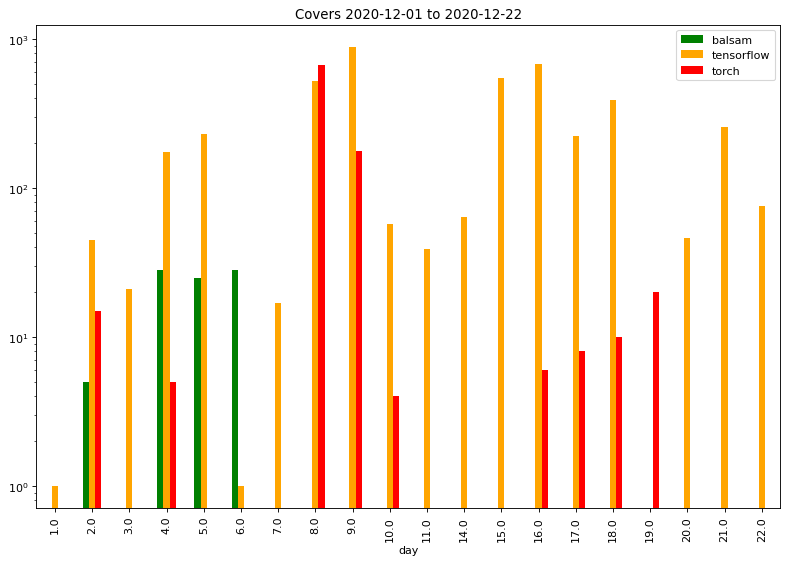

In [328]:
plot_tf_vs_pt(ds)

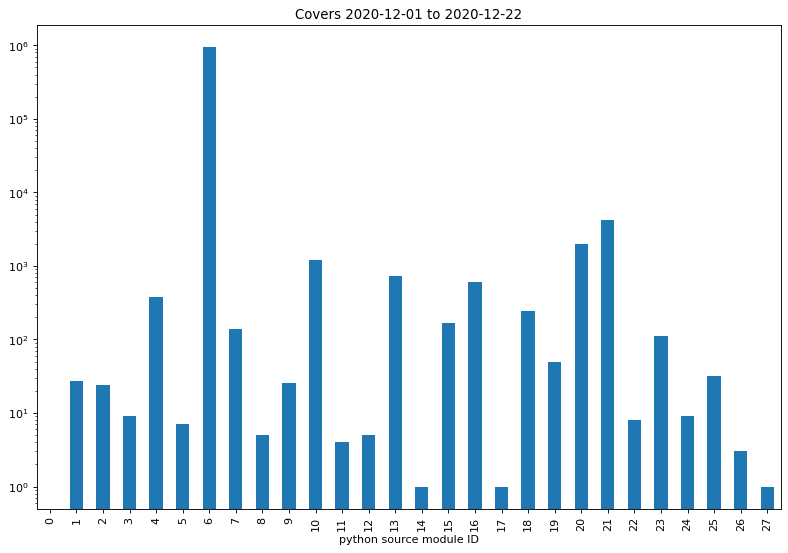

In [329]:
plot_source(ds)

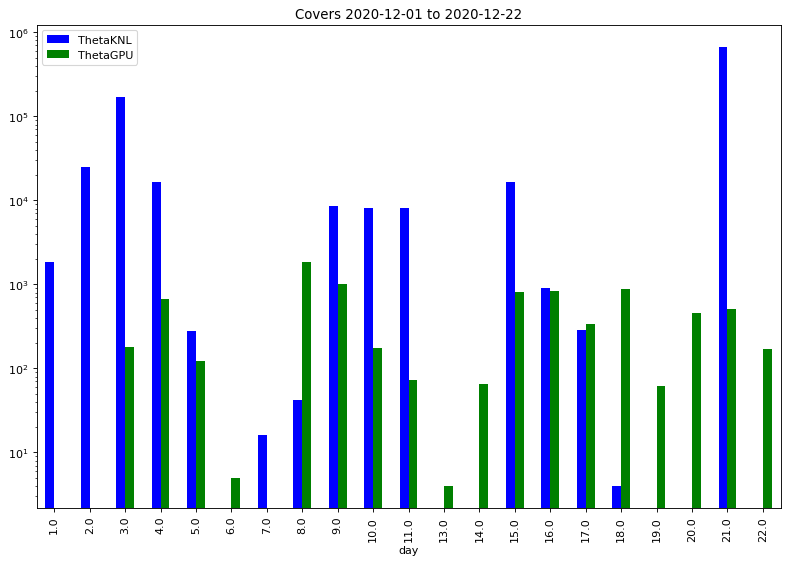

In [330]:
plot_machine(ds)